In [1]:
import sys  
sys.path.insert(0, '../../src/')

from metrics import show_MSE_RMSE_MAE, soft_F_measure

In [2]:
import numpy as np
import keras
import scipy.io as sio
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
import matplotlib.pyplot as plt 
from keras import layers
#from keras.models import Sequential
from keras.models import model_from_json
#from livelossplot.keras import PlotLossesCallback
from IPython.display import clear_output
from keras.utils.vis_utils import plot_model
#from sklearn import preprocessing
#import math

from skimage import feature
from skimage.filters import gaussian

In [3]:
keras.backend.clear_session()

In [4]:
filename = '../../data/raw/MarmousiModel2.mat'
marmousi_cube = sio.loadmat(filename)

### Carregar dados e cubos de Sísmica e Impedância

In [5]:
VP = marmousi_cube['Vp']
#VS = marmousi_cube['Vs']
#IS = marmousi_cube['IS']
pimpedance = marmousi_cube['IP']
seismic = marmousi_cube['seismic']

WAVELET = marmousi_cube['wavelet']

### Parameters 

In [6]:
n_traces = pimpedance.shape[1]

train_wells_loc = np.arange(0,n_traces,135)
all_wells_loc = np.arange(n_traces)

wells_loc = np.array(list(set(all_wells_loc) - set(train_wells_loc)))
valid_wells_loc, unlabed_wells_loc = model_selection.train_test_split(wells_loc,
                                                                      test_size=0.9,
                                                                      train_size=0.1,
                                                                      shuffle=True)
BATCH_SIZE = 10
N_EPOCHS = 2000
noise_dim = 2800
IMG_SHAPE = (2800,1,1)

### Normalizar Sismica

In [7]:
seismic_norm = seismic.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
seismic_norm = seismic_norm.reshape(seismic.shape)
#seismic_norm = seismic

In [8]:
pimpedance_norm = pimpedance.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
pimpedance = pimpedance_norm.reshape(pimpedance.shape)
#seismic_norm = seismic

### Visualizar estatísticas

In [9]:
'''data_info = pd.DataFrame(zip(seismic_norm.flatten(),
                             pimpedance.flatten()),
                         columns=['Seismic CL Stats','PImp CL Stats'])
data_info.describe()'''

"data_info = pd.DataFrame(zip(seismic_norm.flatten(),\n                             pimpedance.flatten()),\n                         columns=['Seismic CL Stats','PImp CL Stats'])\ndata_info.describe()"

### Preparar os Dados

In [10]:
X_train = np.transpose(seismic_norm[:,train_wells_loc])
Y_train = np.transpose(pimpedance[:-1,train_wells_loc])
X_train = np.expand_dims(X_train,axis=(2,3))
Y_train = np.expand_dims(Y_train,axis=(2,3))

X_valid = np.transpose(seismic_norm[:,valid_wells_loc])
Y_valid = np.transpose(pimpedance[:-1,valid_wells_loc])
X_valid = np.expand_dims(X_valid,axis=(2,3))
Y_valid = np.expand_dims(Y_valid,axis=(2,3))

X_test = np.transpose(seismic_norm)
Y_test = np.transpose(pimpedance[:-1,:])
X_test = np.expand_dims(X_test,axis=(2,3))
Y_test = np.expand_dims(Y_test,axis=(2,3))

UNLABED_SEISMIC = np.transpose(seismic_norm[:,unlabed_wells_loc])
UNLABED_SEISMIC = np.expand_dims(UNLABED_SEISMIC,axis=(2,3))

In [11]:
print('     IP (Y_train) shape: ',Y_train.shape)
print('seismic (X_train) shape: ',X_train.shape)

print('     IP (Y_valid) shape: ',Y_valid.shape)
print('seismic (X_valid) shape: ',X_valid.shape)

print('     IP (Y_test) shape: ',Y_test.shape)
print('seismic (X_test) shape: ',X_test.shape)

     IP (Y_train) shape:  (101, 2800, 1, 1)
seismic (X_train) shape:  (101, 2800, 1, 1)
     IP (Y_valid) shape:  (1350, 2800, 1, 1)
seismic (X_valid) shape:  (1350, 2800, 1, 1)
     IP (Y_test) shape:  (13601, 2800, 1, 1)
seismic (X_test) shape:  (13601, 2800, 1, 1)


### Visualizar Dados

Text(0.5, 1.0, 'Output P-Impedance Test - Ground True')

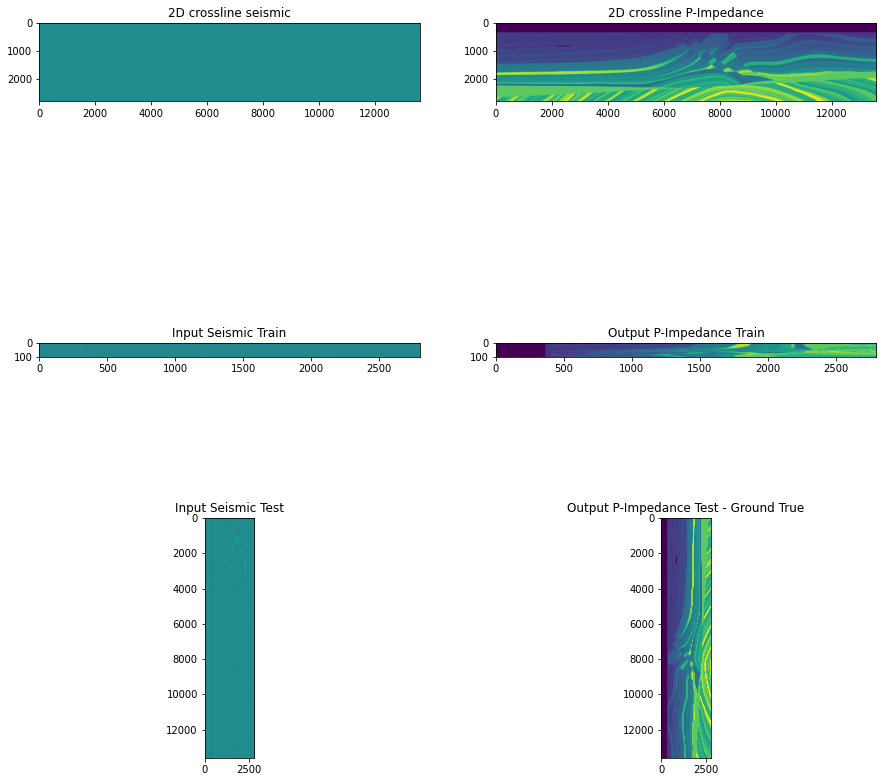

In [12]:
fig1, axes1 = plt.subplots(nrows=3, ncols=2, figsize=(15,15))

axes1[0,0].imshow(seismic)
axes1[0,0].set_title("2D crossline seismic")

axes1[0,1].imshow(pimpedance)
axes1[0,1].set_title("2D crossline P-Impedance")

axes1[1,0].imshow(X_train[:,:,0,0])
axes1[1,0].set_title("Input Seismic Train")

axes1[1,1].imshow(Y_train[:,:,0,0])
axes1[1,1].set_title("Output P-Impedance Train")

axes1[2,0].imshow(X_test[:,:,0,0])
axes1[2,0].set_title("Input Seismic Test")
axes1[2,1].imshow(Y_test[:,:,0,0])
axes1[2,1].set_title("Output P-Impedance Test - Ground True")

## Create and Train Inversion GAN

### Load Forward Model

In [13]:
# load json and create model
json_file = open('forward_model/modelnorm_2d.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
forward_model = model_from_json(loaded_model_json)
# load weights into new model
forward_model.load_weights("forward_model/modelnorm_2d.h5")
print("Loaded forward model from disk")

Loaded forward model from disk


In [14]:
test_forward = False
if test_forward:
    predict = forward_model(Y_test[:6000,:])
    predict = np.transpose(predict[:,:,0].numpy())

In [15]:
if test_forward:
    trace_id = np.random.randint(predict.shape[1])
    plt.plot(predict[0,:,trace_id])
    plt.plot(X_test[trace_id,:,0])
    plt.show()

### Create the generator


In [16]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,1,1))

    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(noise)
    GEN = layers.BatchNormalization()(noise)
    GEN = layers.ReLU()(GEN)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
        
    GEN = layers.Conv2D(filters=1,kernel_size=(3,1),strides=(1,1),padding='same')(GEN)

    GENmodel = keras.models.Model(inputs=noise,outputs=GEN)
    return GENmodel

### Create the discriminator (the critic in the original WGAN)

In [17]:
def get_discriminator_model():       
    input_disc = layers.Input(shape=IMG_SHAPE)        
    ENC = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same',strides=2)(input_disc)
    ENC = layers.LeakyReLU()(ENC)
    ENC = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENC)
        
    ENCB1 = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(ENC)
    ENCB1 = layers.ReLU()(ENCB1)
    ENCB1 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB1)
    ENCB1 = layers.Add()([ENCB1, ENC])
    ENCB1 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB1)
    ENCB1 = layers.ReLU()(ENCB1)
        
    ENCB2 = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(ENCB1)
    ENCB2 = layers.ReLU()(ENCB2)
    ENCB2 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB2)
    ENCB2 = layers.Add()([ENCB2, ENCB1])
    ENCB2 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB2)
    ENCB2 = layers.ReLU()(ENCB1)
        
    ENCB3 = layers.Conv2D(filters=16,kernel_size=(300,1),padding='same')(ENCB2)
    ENCB3 = layers.ReLU()(ENCB3)
    ENCB3 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB3)
    ENCB3 = layers.Add()([ENCB2, ENCB3])
    ENCB3 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB3)
    ENCB3 = layers.ReLU()(ENCB3)
        
    r1 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=1)(ENCB3)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.ReLU()(r1)
    r2 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=3)(ENCB3)
    r2 = layers.BatchNormalization()(r2)
    r2 = layers.ReLU()(r2)
    r3 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=5)(ENCB3)
    r3 = layers.BatchNormalization()(r3)
    r3 = layers.ReLU()(r3)
    r4 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=7)(ENCB3)
    r4 = layers.BatchNormalization()(r4)
    r4 = layers.ReLU()(r4)
    assp = layers.concatenate([r1,r2,r3,r4])
    assp = layers.Conv2D(filters=64,kernel_size=(3,1),padding='same',strides=2)(assp)
        
        
    fc_out = layers.Dense(256,kernel_initializer=tf.keras.initializers.HeNormal())(assp)
    lkr_out = layers.LeakyReLU()(fc_out)
    fc2_outFlatten = layers.Flatten()(lkr_out)
    fc2_out = layers.Dense(1,kernel_initializer=tf.keras.initializers.HeNormal())(fc2_outFlatten)
        
    DISCmodel = keras.models.Model(inputs=input_disc,outputs=fc2_out)
    return DISCmodel

### Create the WGAN-GP models

In [18]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
        alpha_weight = 1000,
        beta_weight = 500
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.alpha_weight = alpha_weight
        self.beta_weight = beta_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, imp_loss_fn, seis_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.imp_loss_fn = imp_loss_fn
        self.seis_loss_fn = seis_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        
        alpha = tf.random.normal([batch_size, 1, 1,1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
       
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        noises_input,real_images = data
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = noises_input
        
        for i in range(self.d_steps):

            with tf.GradientTape() as tape:
                
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)

                real_logits = self.discriminator(real_images, training=True)

                # discriminator loss
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                
                # gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                
                d_loss = d_cost + gp * self.gp_weight 
            
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        # Unlabed seismic mini-batch:
        unlabed_wells_loc = np.arange(UNLABED_SEISMIC.shape[1])
        np.random.shuffle(unlabed_wells_loc)
        unlabed_batch_idxs = unlabed_wells_loc[0:BATCH_SIZE]
        unlabed_batch = UNLABED_SEISMIC[unlabed_batch_idxs,:,:,:]
        
        with tf.GradientTape() as tape:
            
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            
            #Generator loss
            g_cost = self.g_loss_fn(gen_img_logits)
            
            #Impedance loss
            imp_loss = self.imp_loss_fn(generated_images, real_images)
                        
            #Seismic loss:
            fake_seis_unlabed = forward_model(self.generator(unlabed_batch,training=True))
            seis_cost = self.seis_loss_fn(fake_seis_unlabed,unlabed_batch)
            
            g_loss = g_cost + self.alpha_weight * imp_loss + self.beta_weight * seis_cost
            
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        
        return {"d_loss": d_loss, "g_loss": g_loss,"imp_loss":(self.alpha_weight * imp_loss),"seis_loss":(self.beta_weight * seis_cost)}

### CallBacks

In [19]:
checkp_callback = keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                             monitor='imp_loss',
                                             verbose=2,
                                             save_best_only=True,
                                             mode='min')

earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='imp_loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=2, 
            patience=600)

nan_callback = tf.keras.callbacks.TerminateOnNaN()

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.d_losses = []
        self.g_losses = []
        self.imp_losses = []
        self.seis_losses =[]
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.d_losses.append(logs.get('d_loss'))
        self.g_losses.append(logs.get('g_loss'))
        self.imp_losses.append(logs.get('imp_loss'))
        self.seis_losses.append(logs.get('seis_loss'))
        self.i += 1
        
        clear_output(wait=True) 
        if self.i>50:
            plt.plot(self.x[-100:], self.d_losses[-100:], label="d_loss")
            plt.plot(self.x[-100:], self.g_losses[-100:], label="g_loss")
            plt.plot(self.x[-100:], self.imp_losses[-100:], label="imp_loss")
            plt.plot(self.x[-100:], self.seis_losses[-100:], label="seis_loss")
        else:
            plt.plot(self.x, self.d_losses, label="d_loss")
            plt.plot(self.x, self.g_losses, label="g_loss")
            plt.plot(self.x, self.imp_losses, label="imp_loss")
            plt.plot(self.x, self.seis_losses, label="seis_loss")
        plt.legend()
        plt.show();
        
plot_callback = PlotLosses()

### Train the end-to-end model

In [20]:
#Initialize internal models: 
g_model = get_generator_model()
d_model = get_discriminator_model()

#optimizers:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = keras.optimizers.Adam(learning_rate = 0.001)

# All needed losses:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def impedance_loss(fake_imp,real_imp):
    imp_mse = tf.keras.metrics.mean_squared_error(real_imp, fake_imp)
    return imp_mse

def seismic_loss(fake_seis,real_seis):
    seis_loss = tf.keras.metrics.mean_squared_error(real_seis, fake_seis)
    return seis_loss


wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
    alpha_weight = 1000,
    beta_weight = 500,
    gp_weight = 10
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    imp_loss_fn = impedance_loss,
    seis_loss_fn = seismic_loss
)

In [21]:
# Initialize model training:
wgan.fit(X_train,Y_train,
         shuffle=True,
         batch_size=BATCH_SIZE, 
         epochs=N_EPOCHS, 
         verbose = 1,
         #callbacks=[checkp_callback]
        )

Epoch 1/2000
11/11 [==============================] - 32s 399ms/step - d_loss: -44.5495 - g_loss: 4132.1685 - imp_loss: 4074.6758 - seis_loss: 22.5308
Epoch 2/2000
11/11 [==============================] - 3s 315ms/step - d_loss: -16.3507 - g_loss: 136.0367 - imp_loss: 104.0738 - seis_loss: 5.7727
Epoch 3/2000
11/11 [==============================] - 4s 318ms/step - d_loss: 1.8128 - g_loss: 83.5942 - imp_loss: 56.4286 - seis_loss: 3.7007
Epoch 4/2000
11/11 [==============================] - 3s 316ms/step - d_loss: -11.3374 - g_loss: 73.4498 - imp_loss: 43.8514 - seis_loss: 1.8272
Epoch 5/2000
11/11 [==============================] - 4s 321ms/step - d_loss: -11.1647 - g_loss: 74.3912 - imp_loss: 38.9923 - seis_loss: 1.1371
Epoch 6/2000
11/11 [==============================] - 3s 314ms/step - d_loss: -17.7339 - g_loss: 73.5606 - imp_loss: 39.7264 - seis_loss: 1.1534
Epoch 7/2000
11/11 [==============================] - 3s 317ms/step - d_loss: -16.1087 - g_loss: 72.2677 - imp_loss: 37.0545

In [22]:
X_predict = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predict.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predict.shape[0]:
        start_ = X_predict.shape[0]
    if stop_ >= X_predict.shape[0]:
        stop_ = X_predict.shape[0]    
        
    X_predict[start_:stop_,:] = wgan.generator(X_test[start_:stop_,:,:,:])[:,:,0,0]
X_predict = np.transpose(X_predict)

Text(0, 0.5, 'Time (s)')

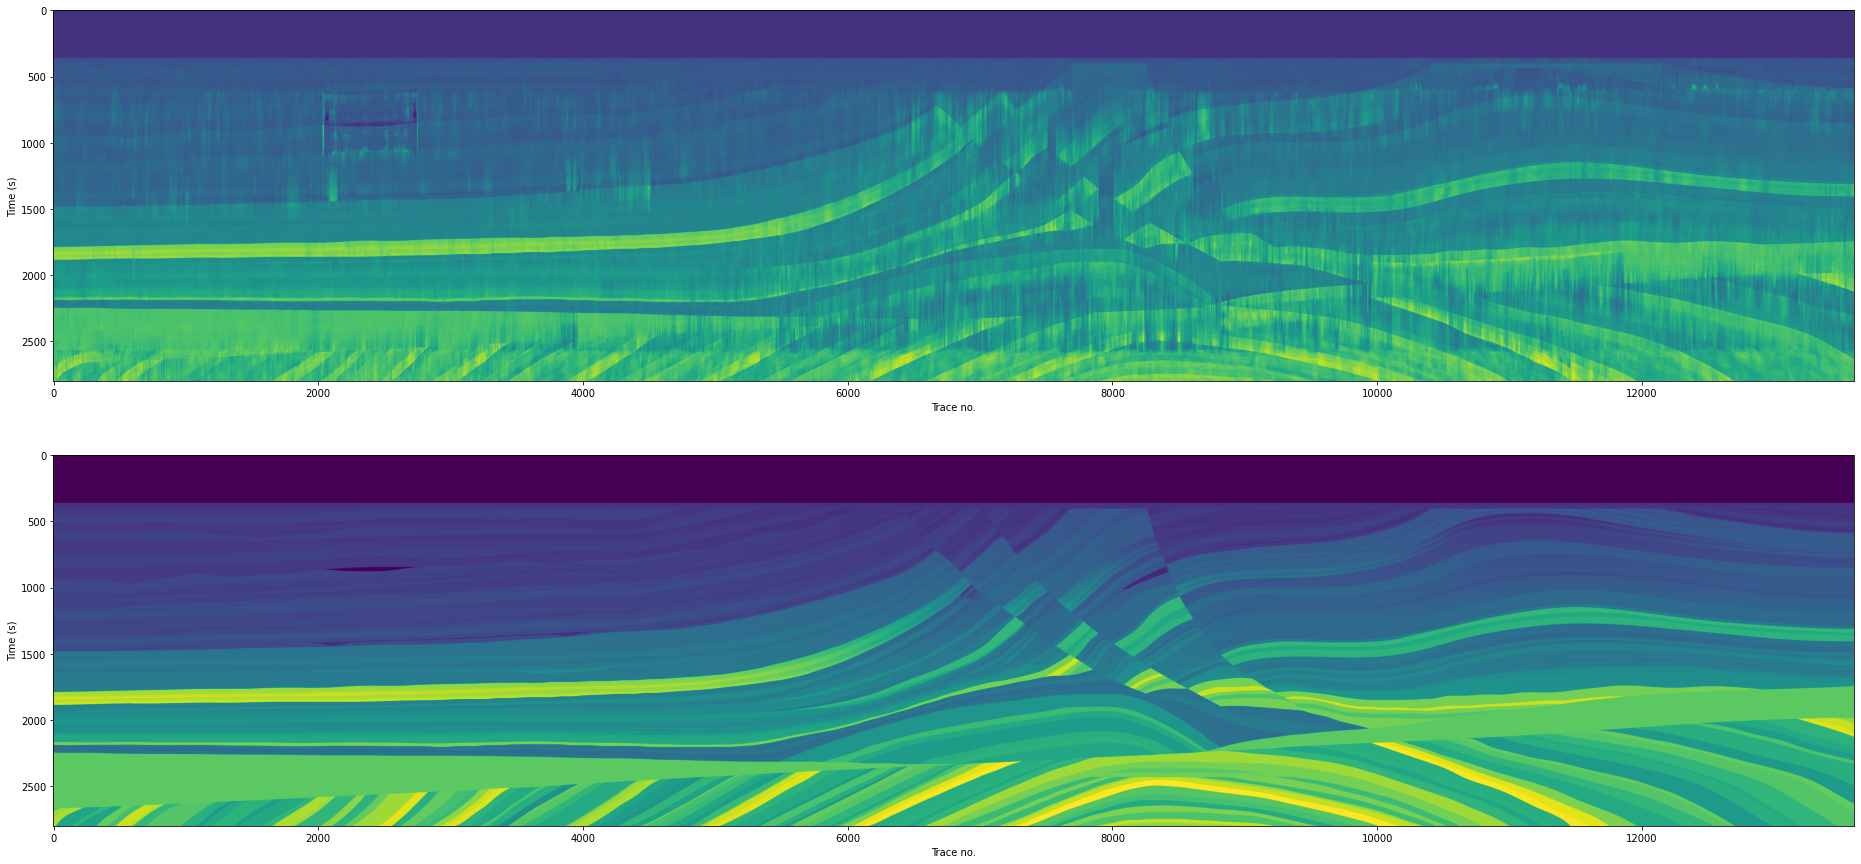

In [23]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(50,15))
axes1[0].imshow(X_predict)
axes1[1].imshow(np.transpose(Y_test[:,:,0,0]))

axes1[0].set_xlabel("Trace no.")
axes1[0].set_ylabel("Time (s)")
axes1[1].set_xlabel("Trace no.")
axes1[1].set_ylabel("Time (s)")

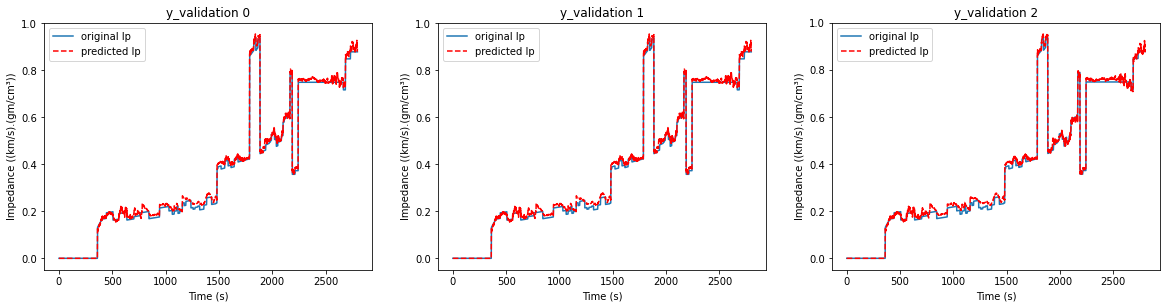

In [24]:
# trace_id = np.random.randint(X_predict.shape[1])
# plt.plot(X_predict[:,trace_id])
# plt.plot(Y_test[trace_id,:,0])
# plt.legend(('predicted','target'))
# plt.title('Trace No.: '+str(trace_id))

test_imp = Y_test[:,:,0,0].T

n = 3
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("y_validation {0}".format(i-1))
    plt.plot(test_imp[:,i-1])
    plt.plot(X_predict[:, i-1], '--r')
    plt.legend(['original Ip', 'predicted Ip'])
    plt.xlabel("Time (s)")
    plt.ylabel("Impedance ((km/s).(gm/cm³))")
plt.show()

In [25]:
original_shape = np.expand_dims(X_predict, axis=2)

predict_image = np.expand_dims(X_predict, axis=2)
predict_image = (predict_image-np.min(predict_image))/(np.max(predict_image)-np.min(predict_image))
predict_image = predict_image.reshape(original_shape.shape)
predict_image = (predict_image).astype('float32')

target_image = np.expand_dims(test_imp, axis=2)
target_image = (target_image-np.min(target_image))/(np.max(target_image)-np.min(target_image))
target_image = target_image.reshape(original_shape.shape)
target_image = target_image.astype('float32')

SSIM = tf.image.ssim(target_image, predict_image, max_val=1).numpy()
MSSIM = tf.image.ssim_multiscale(target_image, predict_image, max_val=1, power_factors=(0.0448, 0.2856, 0.3001, 0.2363)).numpy()
print('SSIM: ', SSIM)
print('SSIM Multiscale: ', MSSIM)

# fig1, axes1 = plt.subplots(nrows=1, ncols=2)
# axes1[0].imshow(predict_image[:,:,0])
# axes1[0].set_title("Predicted")
# axes1[1].imshow(target_image[:,:,0])
# axes1[1].set_title("Target")

(mse_res, mae_res, m) = show_MSE_RMSE_MAE(target_image,
                                          predict_image)

print(f"MSE: ", mse_res)
print("MAE: ", mae_res)
print("RMSE: ", m.result().numpy())

Fb = soft_F_measure(target_data=target_image[:,:,0],
                    predicted_data=predict_image[:,:,0],                 
                    canny_sigma=0.5,
                    gaussian_sigma=0.5,
                    beta_F1=1)

print("Soft F Beta:", Fb)

SSIM:  0.6919658
SSIM Multiscale:  0.8089089
MSE:  0.0127481455
MAE:  0.09574637
RMSE:  0.112907685
Soft F Beta: 0.0909199229575529


In [26]:
# target_image = Y_test[:,:,0,0].T
# predict_image = X_predict[:,:]

# mse_res = tf.keras.metrics.mean_squared_error(target_image.flatten(), predict_image.flatten()).numpy()
# mae_res = tf.keras.metrics.mean_absolute_error(target_image.flatten(), predict_image.flatten()).numpy()

# m = tf.keras.metrics.RootMeanSquaredError()
# m.update_state(target_image.flatten(), predict_image.flatten())

# print("MSE: ", mse_res)
# print("MAE: ", mae_res)
# print("RMSE: ", m.result().numpy())

# mse_res = tf.keras.metrics.mean_squared_error(target_image.flatten(), predict_image.flatten()).numpy()
# mae_res = tf.keras.metrics.mean_absolute_error(target_image.flatten(), predict_image.flatten()).numpy()

# m = tf.keras.metrics.RootMeanSquaredError()
# m.update_state(target_image.flatten(), predict_image.flatten())

# print(f"MSE: ", mse_res)
# print("MAE: ", mae_res)
# print("RMSE: ", m.result().numpy())

## Train baseline: CNN = generator

In [27]:
cnn_inversion = get_generator_model()

optimizer_cnn = keras.optimizers.Adam(learning_rate = 0.001)

cnn_inversion.compile(optimizer=optimizer_cnn, loss='mse', metrics='mse')

In [28]:
cnn_inversion.fit(X_train,Y_train, 
            validation_data=(X_valid,Y_valid),
            epochs=N_EPOCHS,
            verbose=1,
            shuffle=True,
            batch_size=BATCH_SIZE,
           # callbacks = [plot_losses,checkpoint]
           )

Epoch 1/2000
11/11 [==============================] - 3s 191ms/step - loss: 0.4144 - mse: 0.4144 - val_loss: 0.1911 - val_mse: 0.1911
Epoch 2/2000
11/11 [==============================] - 1s 105ms/step - loss: 0.0560 - mse: 0.0560 - val_loss: 0.1389 - val_mse: 0.1389
Epoch 3/2000
11/11 [==============================] - 1s 105ms/step - loss: 0.0363 - mse: 0.0363 - val_loss: 0.1151 - val_mse: 0.1151
Epoch 4/2000
11/11 [==============================] - 1s 106ms/step - loss: 0.0245 - mse: 0.0245 - val_loss: 0.1058 - val_mse: 0.1058
Epoch 5/2000
11/11 [==============================] - 1s 106ms/step - loss: 0.0188 - mse: 0.0188 - val_loss: 0.0928 - val_mse: 0.0928
Epoch 6/2000
11/11 [==============================] - 1s 105ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 7/2000
11/11 [==============================] - 1s 105ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0718 - val_mse: 0.0718
Epoch 8/2000
11/11 [==============================] - 1s 105ms

In [29]:
X_predictCNN = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predictCNN.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predictCNN.shape[0]:
        start_ = X_predictCNN.shape[0]
    if stop_ >= X_predictCNN.shape[0]:
        stop_ = X_predictCNN.shape[0]    
        
    X_predictCNN[start_:stop_,:] = cnn_inversion(X_test[start_:stop_,:,:,:])[:,:,0,0]
X_predictCNN = np.transpose(X_predictCNN)

Text(0, 0.5, 'Time (s)')

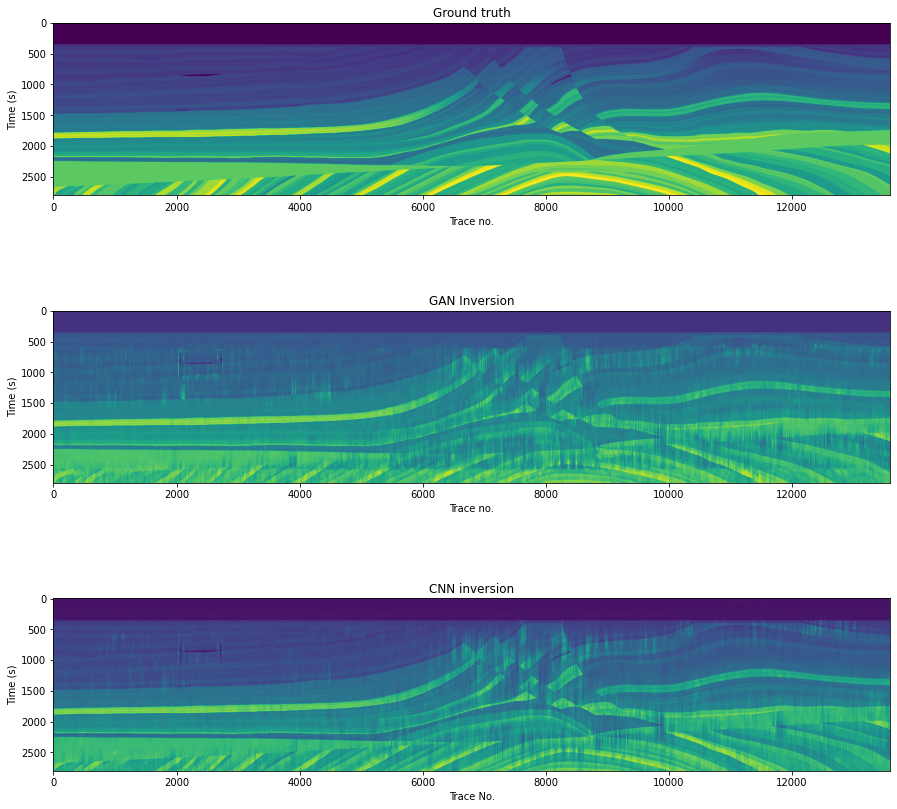

In [30]:
fig1, axes1 = plt.subplots(nrows=3, ncols=1, figsize=(15,15))
axes1[0].imshow(np.transpose(Y_test[:,:,0,0]))
axes1[0].set_title("Ground truth")

axes1[1].imshow(X_predict)
axes1[1].set_title("GAN Inversion")

axes1[2].imshow(X_predictCNN)
axes1[2].set_title("CNN inversion")

axes1[0].set_xlabel("Trace no.")
axes1[0].set_ylabel("Time (s)")
axes1[1].set_xlabel("Trace no.")
axes1[1].set_ylabel("Time (s)")
axes1[2].set_xlabel("Trace No.")
axes1[2].set_ylabel("Time (s)")

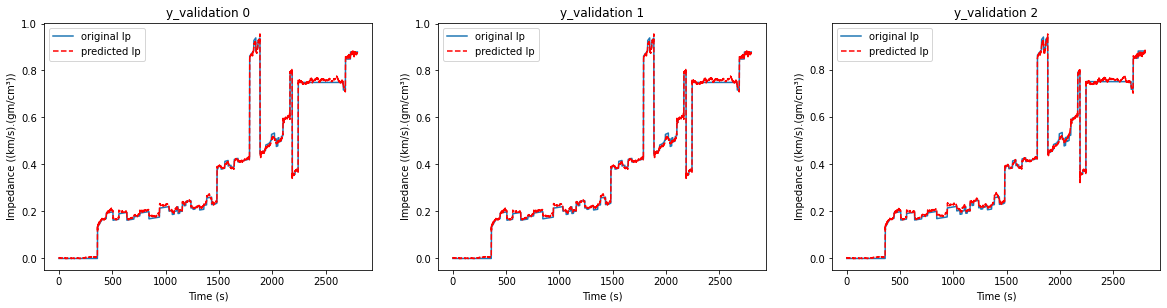

In [32]:
# trace_id = np.random.randint(X_predict.shape[1])
# plt.plot(X_predict[:,trace_id])
# plt.plot(X_predictCNN[:,trace_id])
# plt.plot(Y_test[trace_id,:,0])
# plt.legend(('predicted GAN','predicted CNN','target'))
# plt.title('Trace No.: '+str(trace_id))

n = 3
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("y_validation {0}".format(i-1))
    plt.plot(Y_test[i-1,:,0])
    plt.plot(X_predictCNN[:, i-1], '--r')
    plt.legend(['original Ip', 'predicted Ip'])
    plt.xlabel("Time (s)")
    plt.ylabel("Impedance ((km/s).(gm/cm³))")
plt.show()

# Train the same networks with Noisy Seismic

In [33]:
X_train_wNoise = X_train.copy()
X_valid_wNoise = X_valid.copy()
X_test_wNoise = X_test.copy()

noise_rate = 20

for it in range(X_train_wNoise.shape[0]):
    data_i = X_train_wNoise[it,:,0,0]
    noise_i = np.convolve(np.random.normal(size=(data_i.shape[0],)), WAVELET[:,0], mode='same')
    noise_i = noise_i/np.std(noise_i)
    noise_i = noise_i*np.std(data_i)/np.sqrt(noise_rate)
    
    data_i = data_i + noise_i
    X_train_wNoise[it,:,0,0] = data_i
    
for it in range(X_valid_wNoise.shape[0]):
    data_i = X_valid_wNoise[it,:,0,0]
    noise_i = np.convolve(np.random.normal(size=(data_i.shape[0],)), WAVELET[:,0], mode='same')
    noise_i = noise_i/np.std(noise_i)
    noise_i = noise_i*np.std(data_i)/np.sqrt(noise_rate)
    
    data_i = data_i + noise_i
    X_valid_wNoise[it,:,0,0] = data_i

for it in range(X_test_wNoise.shape[0]):
    data_i = X_test_wNoise[it,:,0,0]
    noise_i = np.convolve(np.random.normal(size=(data_i.shape[0],)), WAVELET[:,0], mode='same')
    noise_i = noise_i/np.std(noise_i)
    noise_i = noise_i*np.std(data_i)/np.sqrt(noise_rate)
    
    data_i = data_i + noise_i
    X_test_wNoise[it,:,0,0] = data_i

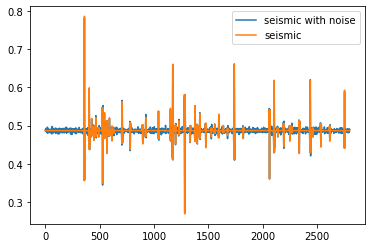

In [34]:
trace_id = np.random.randint(X_train.shape[0])
plt.plot(X_train_wNoise[trace_id,:,0,0])
plt.plot(X_train[trace_id,:,0,0])
plt.legend(('seismic with noise','seismic'))

### WGAN-GP with Noisy Seismic

In [35]:
# Initialize Callbacks
plot_losses_wnoise = PlotLosses()
checkp_callback_wnoise = keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                             monitor='imp_loss',
                                             verbose=2,
                                             save_best_only=True,
                                             mode='min')

In [36]:
#Initialize internal models: 
g_model_wnoise = get_generator_model()
d_model_wnoise = get_discriminator_model()

#optimizers:
generator_optimizer_wnoise = keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer_wnoise = keras.optimizers.Adam(learning_rate = 0.001)

# All needed losses:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def impedance_loss(fake_imp,real_imp):
    imp_mse = tf.keras.metrics.mean_squared_error(real_imp, fake_imp)
    return imp_mse

def seismic_loss(fake_seis,real_seis):
    seis_loss = tf.keras.metrics.mean_squared_error(real_seis, fake_seis)
    return seis_loss

wgan_wnoise = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
    alpha_weight = 1000,
    beta_weight = 500,
    gp_weight = 10
)

wgan_wnoise.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    imp_loss_fn = impedance_loss,
    seis_loss_fn = seismic_loss
)

In [37]:
wgan_wnoise.fit(X_train_wNoise,Y_train,
         shuffle=True,
         batch_size=BATCH_SIZE, 
         epochs=N_EPOCHS, 
         verbose = 1,
         #callbacks=[checkp_callback_wnoise]
        )

Epoch 1/2000
11/11 [==============================] - 20s 317ms/step - d_loss: -0.0998 - g_loss: -71.7543 - imp_loss: 1.6817 - seis_loss: 0.0590
Epoch 2/2000
11/11 [==============================] - 3s 313ms/step - d_loss: -0.0100 - g_loss: -298.2079 - imp_loss: 2.1748 - seis_loss: 0.0645
Epoch 3/2000
11/11 [==============================] - 3s 316ms/step - d_loss: -0.1245 - g_loss: 366.6207 - imp_loss: 2.1914 - seis_loss: 0.0837
Epoch 4/2000
11/11 [==============================] - 4s 319ms/step - d_loss: 0.3476 - g_loss: -82.2625 - imp_loss: 2.6550 - seis_loss: 0.0995
Epoch 5/2000
11/11 [==============================] - 4s 328ms/step - d_loss: -0.1152 - g_loss: -282.0086 - imp_loss: 1.8534 - seis_loss: 0.1035
Epoch 6/2000
11/11 [==============================] - 3s 317ms/step - d_loss: 0.0260 - g_loss: -322.5312 - imp_loss: 1.6911 - seis_loss: 0.0966
Epoch 7/2000
11/11 [==============================] - 3s 316ms/step - d_loss: -0.0531 - g_loss: 50.5208 - imp_loss: 1.7996 - seis_loss

In [38]:
X_predict_wnoise = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predict_wnoise.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predict_wnoise.shape[0]:
        start_ = X_predict_wnoise.shape[0]
    if stop_ >= X_predict_wnoise.shape[0]:
        stop_ = X_predict_wnoise.shape[0]    
        
    X_predict_wnoise[start_:stop_,:] = wgan_wnoise.generator(X_test_wNoise[start_:stop_,:,:,:])[:,:,0,0]
X_predict_wnoise = np.transpose(X_predict_wnoise)

Text(0, 0.5, 'Time (s)')

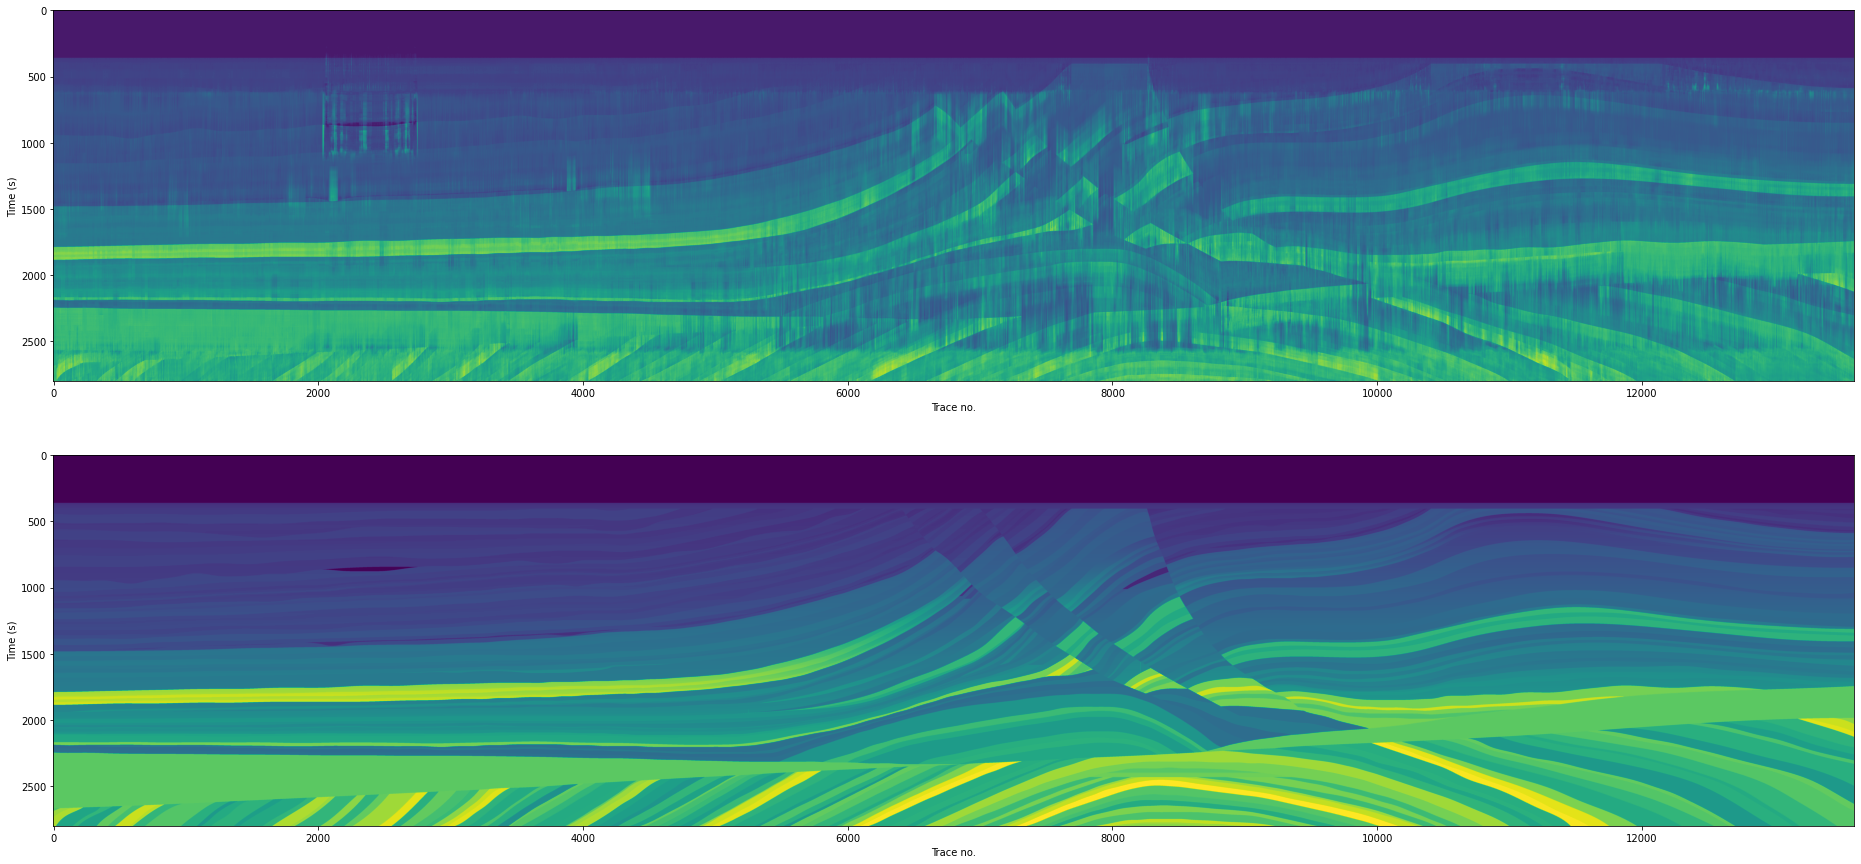

In [39]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(50,15))
axes1[0].imshow(X_predict_wnoise)
axes1[1].imshow(np.transpose(Y_test[:,:,0,0]))

axes1[0].set_xlabel("Trace no.")
axes1[0].set_ylabel("Time (s)")
axes1[1].set_xlabel("Trace no.")
axes1[1].set_ylabel("Time (s)")

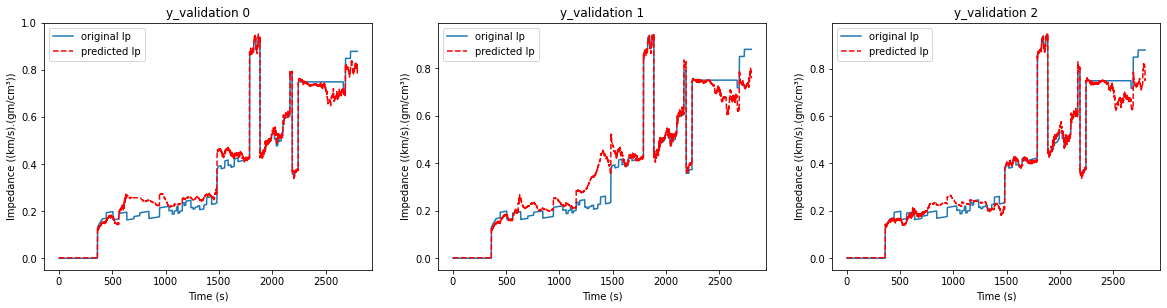

In [40]:
# trace_id = np.random.randint(X_predict.shape[1])
# plt.plot(X_predict_wnoise[:,trace_id])
# plt.plot(Y_test[trace_id,:,0])
# plt.legend(('predicted GAN with noise','target'))
# plt.title('Trace No.: '+str(trace_id))

n = 3
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("y_validation {0}".format(i-1))
    plt.plot(Y_test[i-1, :, 0])
    plt.plot(X_predict_wnoise[:, i-1], '--r')
    plt.legend(['original Ip', 'predicted Ip'])
    plt.xlabel("Time (s)")
    plt.ylabel("Impedance ((km/s).(gm/cm³))")
plt.show()

In [43]:
original_noise_shape = np.expand_dims(X_predict_wnoise, axis=2)

predict_noise_image = np.expand_dims(X_predict_wnoise, axis=2)
predict_noise_image = (predict_noise_image-np.min(predict_noise_image))/(np.max(predict_noise_image)-np.min(predict_noise_image))
predict_noise_image = predict_noise_image.reshape(original_noise_shape.shape)
predict_noise_image = (predict_noise_image).astype('float32')

target_noise_image = np.expand_dims(Y_test, axis=2)
target_noise_image = (target_noise_image-np.min(target_noise_image))/(np.max(target_noise_image)-np.min(target_noise_image))
target_noise_image = target_noise_image.reshape(original_noise_shape.shape)
target_noise_image = target_noise_image.astype('float32')

SSIM = tf.image.ssim(target_noise_image, predict_noise_image, max_val=1).numpy()
MSSIM = tf.image.ssim_multiscale(target_noise_image, predict_noise_image, max_val=1, power_factors=(0.0448, 0.2856, 0.3001, 0.2363)).numpy()
print('SSIM: ', SSIM)
print('SSIM Multiscale: ', MSSIM)

# predict_image = X_predict_wnoise.flatten()
# predict_image = (predict_image-np.min(predict_image))/(np.max(predict_image)-np.min(predict_image))
# predict_image = predict_image.reshape(X_predict_wnoise.shape)
# predict_image = (predict_image).astype('float32')

# target_image = Y_test.flatten()
# target_image = (target_image-np.min(target_image))/(np.max(target_image)-np.min(target_image))
# target_image = target_image.reshape(Y_test[:,:,0,0].shape)
# target_image = target_image.astype('float32')

# SSIM = tf.image.ssim(target_image, predict_image, max_val=1).numpy()
# MSSIM = tf.image.ssim_multiscale(target_image, predict_image, max_val=1, power_factors=(0.0448, 0.2856, 0.3001, 0.2363)).numpy()

# print('SSIM: ', SSIM)
# print('SSIM Multiscale: ', MSSIM)

# fig1, axes1 = plt.subplots(nrows=1, ncols=2)
# axes1[0].imshow(predict_image[:,:,0])
# axes1[0].set_title("Predicted")
# axes1[1].imshow(target_image[:,:,0])
# axes1[1].set_title("Target")

SSIM:  0.015173856
SSIM Multiscale:  0.10013001


In [45]:
target_image_noise = Y_test[:,:,0,0].T
predict_image_noise = X_predict_wnoise[:,:]

mse_res_noise = tf.keras.metrics.mean_squared_error(target_image_noise.flatten(), predict_image_noise.flatten()).numpy()
mae_res_noise = tf.keras.metrics.mean_absolute_error(target_image_noise.flatten(), predict_image_noise.flatten()).numpy()

m_noise = tf.keras.metrics.RootMeanSquaredError()
m.update_state(target_image_noise.flatten(), predict_image_noise.flatten())

print("MSE: ", mse_res_noise)
print("MAE: ", mae_res_noise)
print("RMSE: ", m_noise.result().numpy())

# Fb = soft_F_measure(target_data=target_image_noise[:,:,0],
#                     predicted_data=predict_image_noise[:,:,0],                 
#                     canny_sigma=0.5,
#                     gaussian_sigma=0.5,
#                     beta_F1=1)

# print("Soft F Beta:", Fb)

MSE:  0.008228718561609474
MAE:  0.052754967233116484
RMSE:  0.0


### CNN Inversion with Noisy Seismic

In [46]:
cnn_inversion_wnoise = get_generator_model()
optimizer_cnn_wnoise = keras.optimizers.Adam(learning_rate = 0.001)

cnn_inversion_wnoise.compile(optimizer=optimizer_cnn_wnoise, loss='mse', metrics='mse')
cnn_inversion_wnoise.fit(X_train_wNoise,Y_train, 
            validation_data=(X_valid_wNoise,Y_valid),
            epochs=N_EPOCHS,
            verbose=1,
            shuffle=True,
            batch_size=BATCH_SIZE,
           # callbacks = [plot_losses,checkpoint]
           )

Epoch 1/2000
11/11 [==============================] - 2s 124ms/step - loss: 2.8641 - mse: 2.8641 - val_loss: 0.2270 - val_mse: 0.2270
Epoch 2/2000
11/11 [==============================] - 1s 103ms/step - loss: 0.2159 - mse: 0.2159 - val_loss: 0.2032 - val_mse: 0.2032
Epoch 3/2000
11/11 [==============================] - 1s 104ms/step - loss: 0.1303 - mse: 0.1303 - val_loss: 0.1483 - val_mse: 0.1483
Epoch 4/2000
11/11 [==============================] - 1s 105ms/step - loss: 0.0775 - mse: 0.0775 - val_loss: 2.2514 - val_mse: 2.2514
Epoch 5/2000
11/11 [==============================] - 1s 103ms/step - loss: 0.0709 - mse: 0.0709 - val_loss: 18.2676 - val_mse: 18.2676
Epoch 6/2000
11/11 [==============================] - 1s 105ms/step - loss: 0.0657 - mse: 0.0657 - val_loss: 42.2992 - val_mse: 42.2992
Epoch 7/2000
11/11 [==============================] - 1s 107ms/step - loss: 0.0612 - mse: 0.0612 - val_loss: 49.4927 - val_mse: 49.4927
Epoch 8/2000
11/11 [==============================] - 1s

In [47]:
X_predictCNN_wnoise = np.zeros(Y_test.shape[0:2])
for i in range(round((X_predictCNN_wnoise.shape[0])/1000)):
    start_,stop_ = (i*1000),(i+1)*1000
    if start_ >= X_predictCNN_wnoise.shape[0]:
        start_ = X_predictCNN_wnoise.shape[0]
    if stop_ >= X_predictCNN_wnoise.shape[0]:
        stop_ = X_predictCNN_wnoise.shape[0]    
        
    X_predictCNN_wnoise[start_:stop_,:] = cnn_inversion_wnoise(X_test_wNoise[start_:stop_,:,:,:])[:,:,0,0]
X_predictCNN_wnoise = np.transpose(X_predictCNN_wnoise)   

Text(0, 0.5, 'Time (s)')

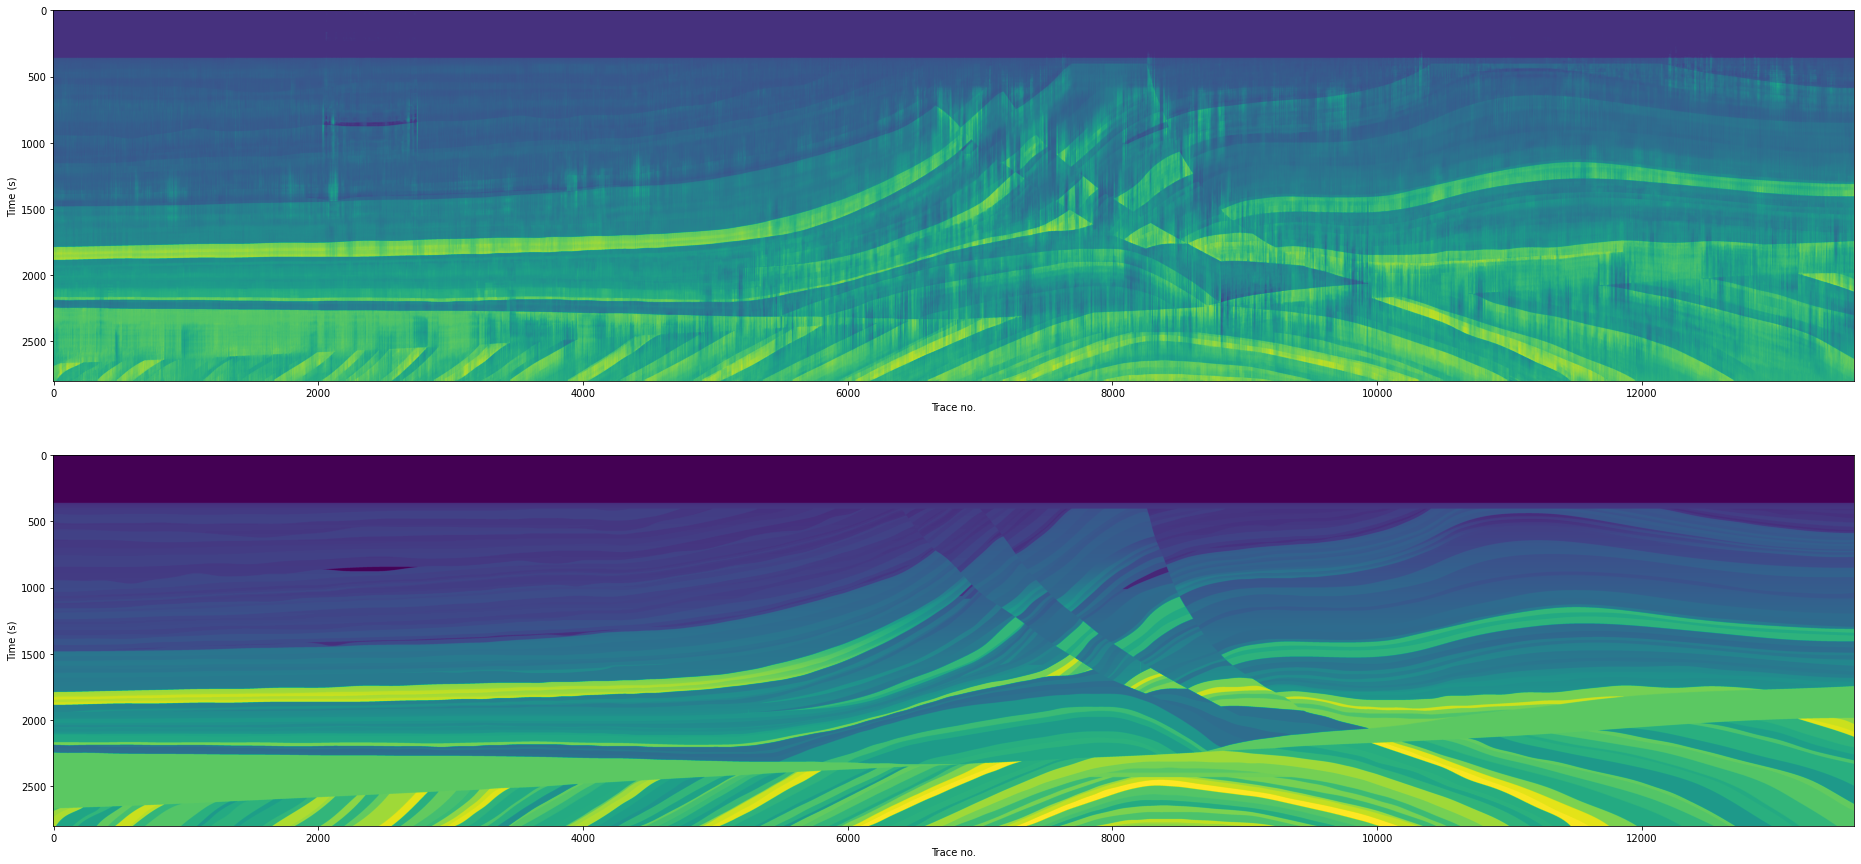

In [48]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(50,15))
axes1[0].imshow(X_predictCNN_wnoise)
axes1[1].imshow(np.transpose(Y_test[:,:,0,0]))

axes1[0].set_xlabel("Trace no.")
axes1[0].set_ylabel("Time (s)")
axes1[1].set_xlabel("Trace no.")
axes1[1].set_ylabel("Time (s)")

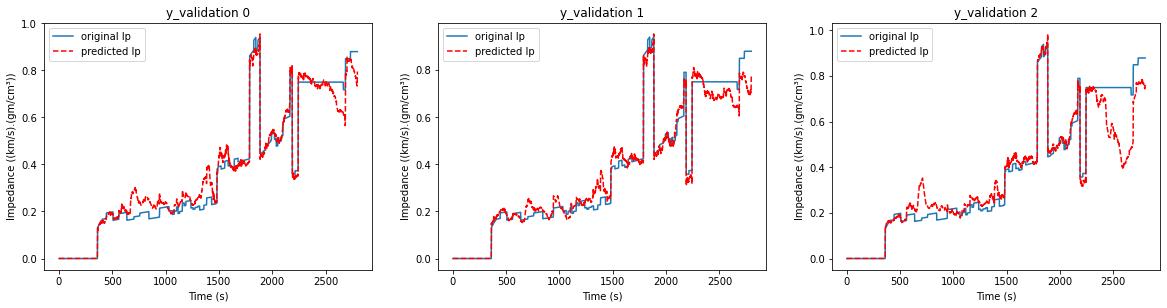

In [49]:
# trace_id = np.random.randint(X_predict.shape[1])
# plt.plot(X_predict_wnoise[:,trace_id])
# plt.plot(X_predictCNN_wnoise[:,trace_id])
# plt.plot(Y_test[trace_id,:,0])
# plt.legend(('predicted GAN with noise','predicted CNN with noise','target'))
# plt.title('Trace No.: '+str(trace_id))

n = 3
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    ax.set_title("y_validation {0}".format(i-1))
    plt.plot(Y_test[i-1, :, 0])
    plt.plot(X_predictCNN_wnoise[:, i-1], '--r')
    plt.legend(['original Ip', 'predicted Ip'])
    plt.xlabel("Time (s)")
    plt.ylabel("Impedance ((km/s).(gm/cm³))")
plt.show()

In [51]:
original_shape = np.expand_dims(X_predictCNN_wnoise, axis=2)

predict_image = np.expand_dims(X_predictCNN_wnoise, axis=2)
predict_image = (predict_image-np.min(predict_image))/(np.max(predict_image)-np.min(predict_image))
predict_image = predict_image.reshape(original_shape.shape)
predict_image = (predict_image).astype('float32')

target_image = np.expand_dims(Y_test, axis=2)
target_image = (target_image-np.min(target_image))/(np.max(target_image)-np.min(target_image))
target_image = target_image.reshape(original_shape.shape)
target_image = target_image.astype('float32')

SSIM = tf.image.ssim(target_image, predict_image, max_val=1).numpy()
MSSIM = tf.image.ssim_multiscale(target_image, predict_image, max_val=1, power_factors=(0.0448, 0.2856, 0.3001, 0.2363)).numpy()
print('SSIM: ', SSIM)
print('SSIM Multiscale: ', MSSIM)

# predict_image = X_predictCNN_wnoise.flatten()
# predict_image = (predict_image-np.min(predict_image))/(np.max(predict_image)-np.min(predict_image))
# predict_image = predict_image.reshape(X_predictCNN_wnoise.shape)
# predict_image = (predict_image).astype('float32')

# target_image = Y_test.flatten()
# target_image = (target_image-np.min(target_image))/(np.max(target_image)-np.min(target_image))
# target_image = target_image.reshape(Y_test[:,:,0,0].shape)
# target_image = target_image.astype('float32')

# SSIM = tf.image.ssim(target_image, predict_image, max_val=1).numpy()
# MSSIM = tf.image.ssim_multiscale(target_image, predict_image, max_val=1, power_factors=(0.0448, 0.2856, 0.3001, 0.2363)).numpy()

# print('SSIM: ', SSIM)
# print('SSIM Multiscale: ', MSSIM)

target_image_noise = Y_test[:,:,0,0].T
predict_imageCNN_noise = X_predictCNN_wnoise[:,:]

mse_resCNN_noise = tf.keras.metrics.mean_squared_error(target_image_noise.flatten(), predict_image_noise.flatten()).numpy()
mae_resCNN_noise = tf.keras.metrics.mean_absolute_error(target_image_noise.flatten(), predict_image_noise.flatten()).numpy()

m_noise = tf.keras.metrics.RootMeanSquaredError()
m.update_state(target_image_noise.flatten(), predict_imageCNN_noise.flatten())

print("MSE: ", mse_resCNN_noise)
print("MAE: ", mae_resCNN_noise)
print("RMSE: ", m_noise.result().numpy())

Fb = soft_F_measure(target_data=target_image_noise[:,:,0],
                    predicted_data=predict_imageCNN_noise[:,:,0],                 
                    canny_sigma=0.5,
                    gaussian_sigma=0.5,
                    beta_F1=1)

print("Soft F Beta:", Fb)

SSIM:  0.01597858
SSIM Multiscale:  0.101834305
MSE:  0.008228718561609474
MAE:  0.052754967233116484
RMSE:  0.0


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed